In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.75G/1.76G [00:12<00:00, 150MB/s]
100% 1.76G/1.76G [00:12<00:00, 146MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

In [ ]:
from zipfile import ZipFile

data_path = '/content/lung-and-colon-cancer-histopathological-images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


In [ ]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_n', 'lung_aca', 'lung_scc']

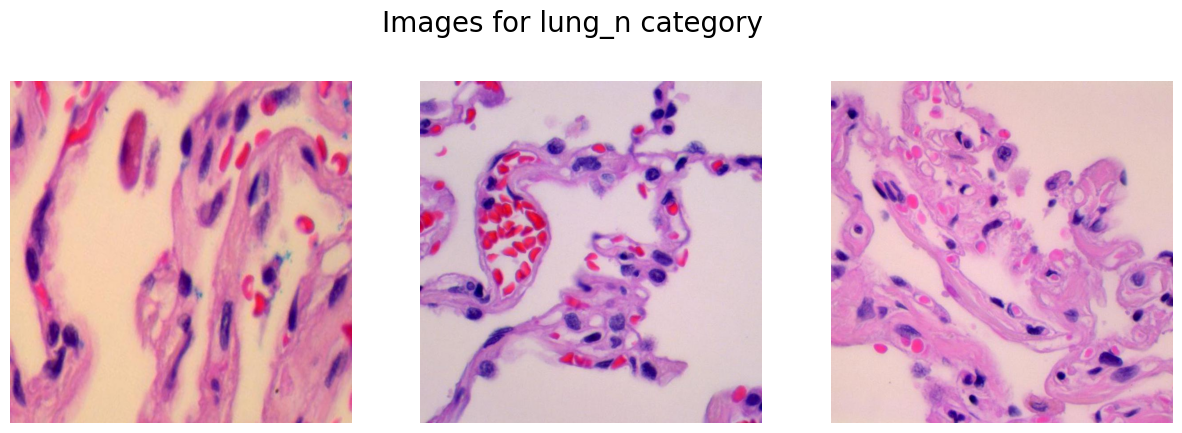

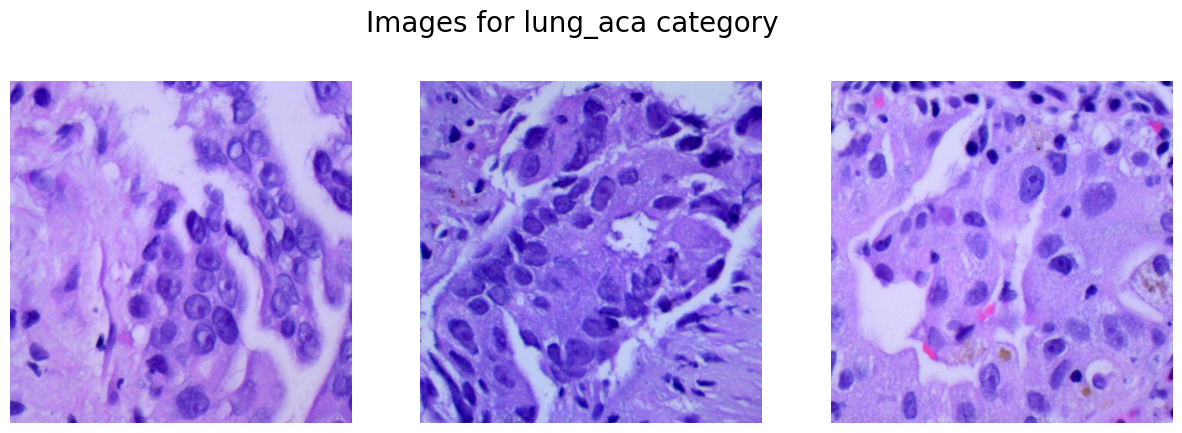

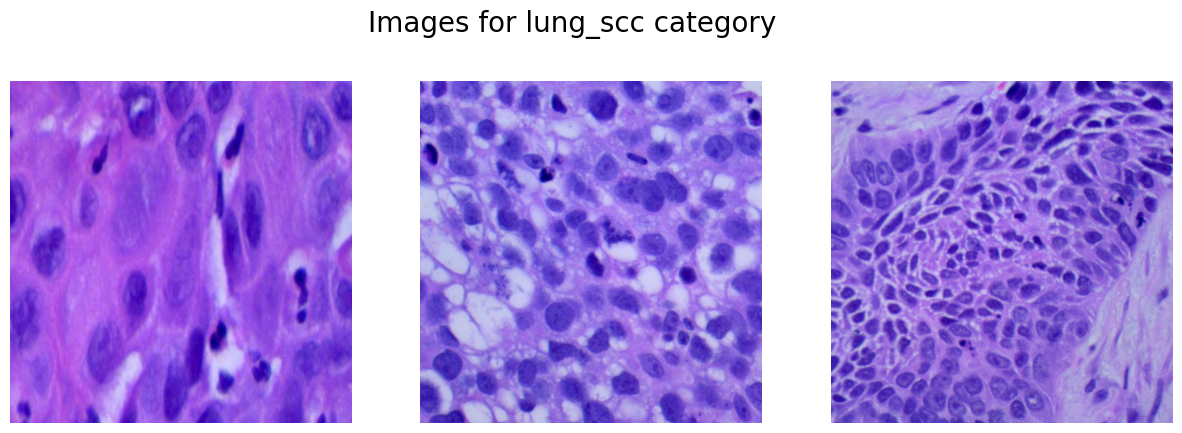

In [ ]:
path = '/content/lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 32

In [ ]:
X = []
y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        y.append(i)

X = np.asarray(X)
y = pd.get_dummies(y).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=42)

X_train shape: (12000, 256, 256, 3)
X_test shape: (3000, 256, 256, 3)


In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters = 16,
                  kernel_size = (5,5),
                  activation = 'relu',
                  input_shape = (IMG_SIZE, IMG_SIZE, 3),
                  padding = 'same'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(filters = 32,
                  kernel_size = (3,3),
                  activation = 'relu',
                  input_shape = (IMG_SIZE, IMG_SIZE, 3),
                  padding = 'same'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(filters = 64,
                  kernel_size = (3,3),
                  activation = 'relu',
                  input_shape = (IMG_SIZE, IMG_SIZE, 3),
                  padding = 'same'),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto 90%, hence stopping the further training')
            self.model.stop_training = True

early_stopping = EarlyStopping(patience = 3,
                               monitor = 'val_accuarcy',
                               restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [early_stopping, lr, myCallback()])

Epoch 1/5
375/375 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8238

375/375 [==============================] - 151s 399ms/step - loss: 0.4188 - accuracy: 0.8238 - val_loss: 3.5041 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 2/5
375/375 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8941

375/375 [==============================] - 148s 395ms/step - loss: 0.2710 - accuracy: 0.8941 - val_loss: 1.9492 - val_accuracy: 0.5183 - lr: 0.0010
Epoch 3/5
375/375 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9122

375/375 [==============================] - 147s 392ms/step - loss: 0.2353 - accuracy: 0.9122 - val_loss: 1.1209 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 4/5
375/375 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9176

375/375 [==============================] - 148s 393ms/step - loss: 0.2063 - accuracy: 0.9176 - val_loss: 0.9922 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 5/5
375/375 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9262

375/375 [==============================] - 147s 392ms/step - loss: 0.1935 - accuracy: 0.9262 - val_loss: 0.9855 - val_accuracy: 0.7170 - lr: 0.0010


<Axes: >

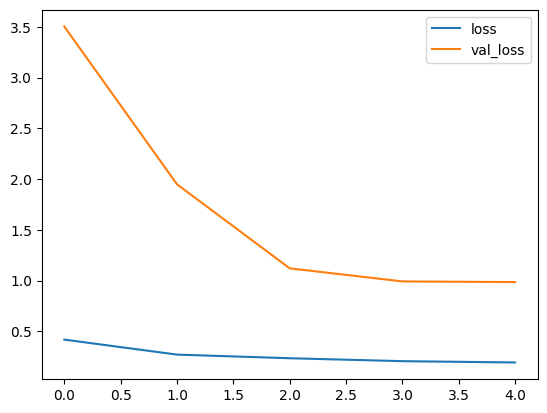

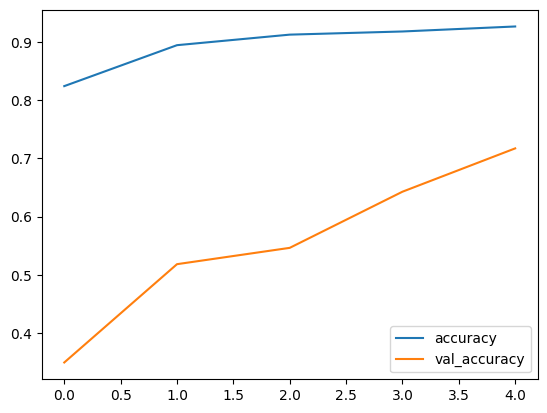

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

94/94 [==============================] - 6s 60ms/step


In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=classes))


              precision    recall  f1-score   support

      lung_n       0.65      1.00      0.79      1037
    lung_aca       0.95      0.15      0.26       970
    lung_scc       0.78      0.97      0.86       993

    accuracy                           0.72      3000
   macro avg       0.79      0.71      0.64      3000
weighted avg       0.79      0.72      0.64      3000



In [ ]:
model.save('lung_cancer_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
